In [8]:
import pandas as pd
import numpy as np
import re
import string
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ProjectsAI_CodeInjection/Dataset

Mounted at /content/drive
/content/drive/MyDrive/ProjectsAI_CodeInjection/Dataset


In [4]:
data = pd.read_csv("dataset_capec.csv")
data.head()

,text,label
0,GET /blog/index.php/2020/04/04/voluptatum-repr...,000 - Normal
1,GET /blog/xmlrpc.php?rsd,000 - Normal
2,GET /blog/index.php/2020/04/04/nihil-tenetur-e...,000 - Normal
3,GET /blog/index.php/2020/04/04/explicabo-qui-f...,000 - Normal
4,GET /blog/index.php/2020/04/04/explicabo-qui-f...,000 - Normal


66 - SQL Injection                        248093
000 - Normal                              226509
194 - Fake the Source of Data              55982
34 - HTTP Response Splitting               19134
126 - Path Traversal                       17595
242 - Code Injection                       13792
272 - Protocol Manipulation                 6924
310 - Scanning for Vulnerable Software      2382
153 - Input Data Manipulation               1387
Name: label, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '66 - SQL Injection'),
  Text(1, 0, '000 - Normal'),
  Text(2, 0, '194 - Fake the Source of Data'),
  Text(3, 0, '34 - HTTP Response Splitting'),
  Text(4, 0, '126 - Path Traversal'),
  Text(5, 0, '242 - Code Injection'),
  Text(6, 0, '272 - Protocol Manipulation'),
  Text(7, 0, '310 - Scanning for Vulnerable Software'),
  Text(8, 0, '153 - Input Data Manipulation')])

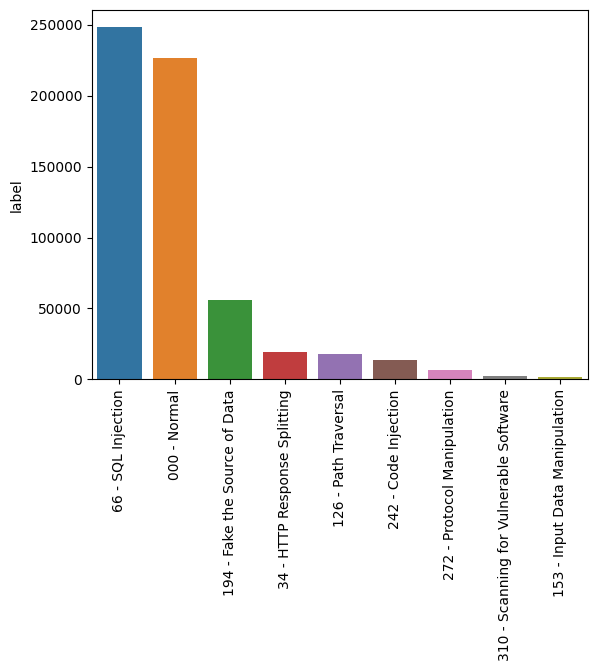

In [9]:
# Class Distribution
# if dataset is balanced or not
x = data['label'].value_counts(normalize =False,
                                   sort = True,
                                   ascending = False,
                                   bins = None,
                                   dropna = True)
print(x)
sns.barplot(x = x.index, y = x)
plt.xticks(rotation = 90)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import json

class Vectorizer:
    def __init__(self, method, ngram_range=(1, 1), max_features=300, emb_fname='', word_index_fname=''):
        self.method = method
        if (method == 'BOW'):
            self.vectorizer = CountVectorizer(analyzer='word', input='content', ngram_range=ngram_range, max_features=max_features)
        elif (self.method == 'TFIDF'):
            self.vectorizer = TfidfVectorizer(analyzer='word', input='content', max_features=max_features)
        elif (self.method == 'Word2vec'):
            self.max_features = max_features
            self.emb_fname = emb_fname
            self.word_index_fname = word_index_fname
        else:
            raise ValueError('Feature extraction method does not exist.')

    def feature_extraction(self, x_train, x_val):
        train_data = self.vectorizer.fit_transform(x_train).toarray()
        test_data = self.vectorizer.transform(x_val).toarray()
        return train_data, test_data

    def get_word_index(self):
        word2id = json.load(open(self.word_index_fname, 'r'))
        return word2id

    def get_embedding_matrix(self):
        np.random.seed(0)
        word2id = self.get_word_index()
        embedding_matrix = np.random.uniform(-0.25, 0.25, [len(word2id)+1, self.max_features])
        with open(self.emb_fname, 'r', encoding='utf-8') as f:
            for line in f:
                content = line.split(' ')
                if content[0] in word2id:
                    embedding_matrix[word2id[content[0]]]= np.array(list(map(float, content[1:])))
        return embedding_matrix

In [13]:
data['text'] = data['text'].str.replace('/',' ')
data.head()

,text,label
0,GET blog index.php 2020 04 04 voluptatum-repr...,000 - Normal
1,GET blog xmlrpc.php?rsd,000 - Normal
2,GET blog index.php 2020 04 04 nihil-tenetur-e...,000 - Normal
3,GET blog index.php 2020 04 04 explicabo-qui-f...,000 - Normal
4,GET blog index.php 2020 04 04 explicabo-qui-f...,000 - Normal


In [23]:
x_train, x_val, y_train, y_val = train_test_split(data["text"],
                                                  data["label"],
                                                  test_size=0.2,
                                                  shuffle=True)

vectorizer = Vectorizer('TFIDF')
train_features, test_features = vectorizer.feature_extraction(x_train, x_val)


In [24]:
rlist =['000 - Normal', '126 - Path Traversal',
       '153 - Input Data Manipulation', '194 - Fake the Source of Data',
       '242 - Code Injection', '272 - Protocol Manipulation',
       '310 - Scanning for Vulnerable Software',
       '34 - HTTP Response Splitting', '66 - SQL Injection']

In [25]:
mapping = {l: i for i, l in enumerate(rlist)}
mapping

{'000 - Normal': 0,
 '126 - Path Traversal': 1,
 '153 - Input Data Manipulation': 2,
 '194 - Fake the Source of Data': 3,
 '242 - Code Injection': 4,
 '272 - Protocol Manipulation': 5,
 '310 - Scanning for Vulnerable Software': 6,
 '34 - HTTP Response Splitting': 7,
 '66 - SQL Injection': 8}

In [26]:
mapping['000 - Normal']

0

In [27]:
y_train = [mapping[s] for s in y_train]
y_test = [mapping[r] for r in y_val]

In [28]:
from keras.utils.np_utils import to_categorical

In [29]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = to_categorical(y_train, num_classes=9)
y_test = to_categorical(y_test ,num_classes=9)

In [31]:
x_train.shape

(473438,)

In [35]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=100))
model.add(GRU(units=32))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, validation_data=(x_val, y_test), epochs=5, batch_size=64)

# Đánh giá mô hình
y_pred = model.predict(x_val)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred, target_names=rlist, labels= range(9)))

Epoch 1/5


UnimplementedError: ignored

In [ ]:
y_test


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [ ]:
y_predict = np.argmax(y_pred , axis=1)
y_test_pre = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_pre, y_predict)

In [ ]:
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt

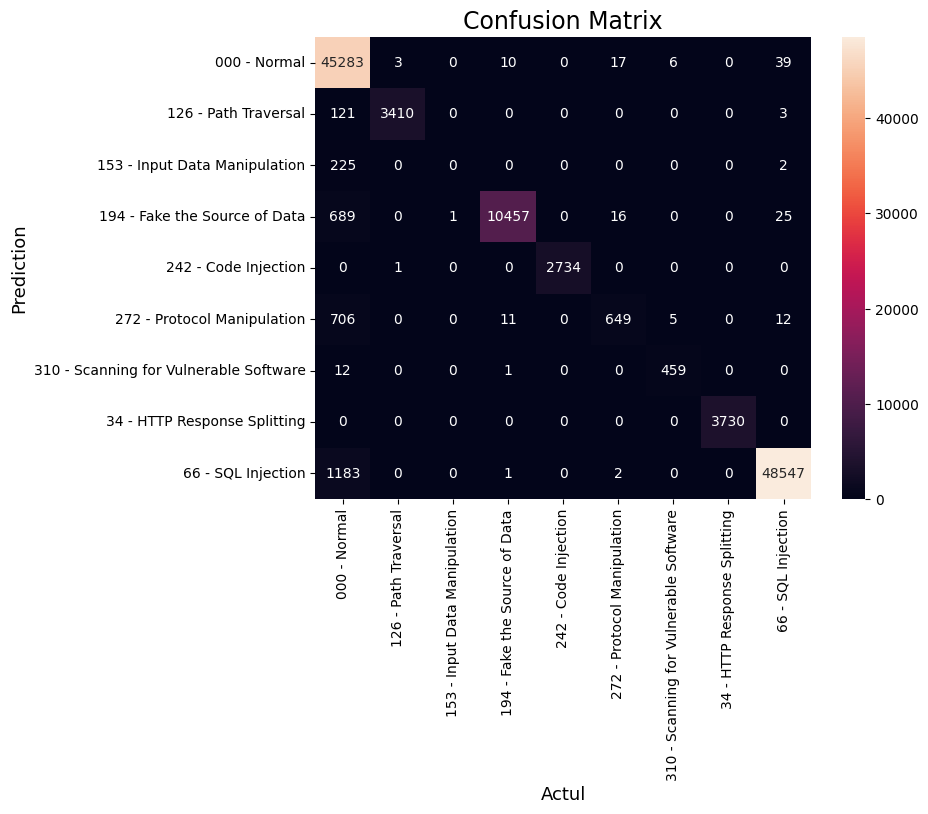

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='g',xticklabels = rlist,yticklabels= rlist)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actul',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

# LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=5000, output_dim=64, input_length=100))
model_lstm.add(LSTM(units=32))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(9, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)

# Đánh giá mô hình
y_pred = model_lstm.predict(X_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred, target_names=rlist, labels=range(9)))

Epoch 1/5
7398/7398 [==============================] - 615s 83ms/step - loss: 0.1700 - accuracy: 0.9534 - val_loss: 0.0993 - val_accuracy: 0.9722
Epoch 2/5
7398/7398 [==============================] - 606s 82ms/step - loss: 0.0987 - accuracy: 0.9714 - val_loss: 0.0883 - val_accuracy: 0.9738
Epoch 3/5
7398/7398 [==============================] - 597s 81ms/step - loss: 0.0905 - accuracy: 0.9734 - val_loss: 0.0840 - val_accuracy: 0.9755
Epoch 4/5
7398/7398 [==============================] - 601s 81ms/step - loss: 0.0863 - accuracy: 0.9744 - val_loss: 0.0829 - val_accuracy: 0.9753
Epoch 5/5
3699/3699 [==============================] - 59s 16ms/step
                                        precision    recall  f1-score   support

                          000 - Normal       0.95      1.00      0.97     45358
                  126 - Path Traversal       1.00      0.96      0.98      3534
         153 - Input Data Manipulation       0.00      0.00      0.00       227
         194 - Fake the So

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_predict = np.argmax(y_pred , axis=1)
y_test_pre = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_pre, y_predict)

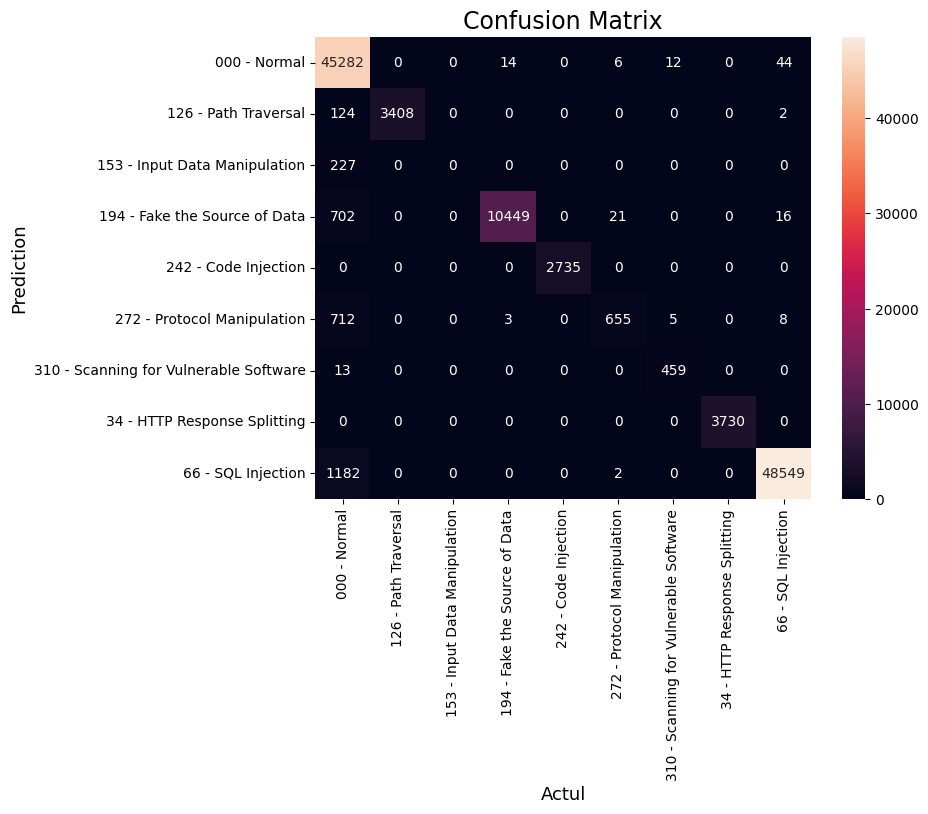

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='g',xticklabels = rlist,yticklabels= rlist)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actul',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [ ]:
# 2 LSTM layers
model_lstm_1 = Sequential()
model_lstm_1.add(Embedding(input_dim=5000, output_dim=64, input_length=100))
model_lstm_1.add(LSTM(units=32,return_sequences=True))
model_lstm_1.add(LSTM(units=32))
model_lstm_1.add(Dropout(0.2))
model_lstm_1.add(Dense(9, activation='softmax'))

model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)

# Đánh giá mô hình
y_pred = model_lstm_1.predict(X_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred, target_names=rlist, labels=range(9)))

Epoch 1/5
7398/7398 [==============================] - 1081s 145ms/step - loss: 0.1596 - accuracy: 0.9565 - val_loss: 0.1161 - val_accuracy: 0.9674
Epoch 2/5
7398/7398 [==============================] - 1092s 148ms/step - loss: 0.0974 - accuracy: 0.9716 - val_loss: 0.0990 - val_accuracy: 0.9719
Epoch 3/5
7398/7398 [==============================] - 1098s 148ms/step - loss: 0.0893 - accuracy: 0.9735 - val_loss: 0.0851 - val_accuracy: 0.9749
Epoch 4/5
7398/7398 [==============================] - 1077s 146ms/step - loss: 0.0855 - accuracy: 0.9745 - val_loss: 0.0825 - val_accuracy: 0.9756
Epoch 5/5
3699/3699 [==============================] - 104s 28ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score   support

                          000 - Normal       0.95      1.00      0.97     45358
                  126 - Path Traversal       1.00      0.96      0.98      3534
         153 - Input Data Manipulation       0.00      0.00      0.00       227
         194 - Fake the Source of Data       1.00      0.93      0.97     11188
                  242 - Code Injection       1.00      1.00      1.00      2735
           272 - Protocol Manipulation       0.95      0.46      0.62      1383
310 - Scanning for Vulnerable Software       0.97      0.98      0.97       472
          34 - HTTP Response Splitting       1.00      1.00      1.00      3730
                    66 - SQL Injection       1.00      0.98      0.99     49733

                             micro avg       0.98      0.97      0.98    118360
                             macro avg       0.87      0.81      0.83    118360
                          weighted avg

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
